# Classify B-ALL

- After every kernel restart rerun "Core"
- It's best to restart after you run a training process

## Core (Always run)

In [ ]:
%%sql


Imports

In [205]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import time
import os

import shap
import optuna

from sklearn.decomposition import PCA
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, auc, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

Global Variables

In [128]:
start_time = time.time()

path_to_data = "data/"

### Preprocess

Load Datasets

In [129]:
b_all_df = pd.read_parquet(f"{path_to_data}B_ALL.pq")
all_df = pd.read_parquet(f"{path_to_data}ALL.pq")

#### Merging

In [130]:
b_all_length = len(b_all_df.columns.drop(['gene_name', 'gene_type']))
all_length = len(all_df.columns.drop(['gene_name', 'gene_type']))

total_length = b_all_length + all_length

df_b_all_filtered = b_all_df[b_all_df['gene_type'] == 'protein_coding']
df_all_filtered = all_df[all_df['gene_type'] == 'protein_coding']

df_b_all_filtered = df_b_all_filtered.drop(['gene_name', 'gene_type'], axis=1)
df_all_filtered = df_all_filtered.drop(['gene_name', 'gene_type'], axis=1)

df_b_all_filtered = df_b_all_filtered.fillna(0).select_dtypes(include='number').T
df_all_filtered = df_all_filtered.fillna(0).select_dtypes(include='number').T

print("Filtered B-ALL length:", len(df_b_all_filtered))
print("Filtered ALL length:", len(df_all_filtered))

combined_df = pd.concat([df_b_all_filtered, df_all_filtered], axis=0)

combined_df['condition'] = [1] * len(df_all_filtered) + [0] * len(df_b_all_filtered)

if (len(df_b_all_filtered) + len(df_all_filtered)) != combined_df.shape[0]:
    print(f"Expected number of rows: {len(df_b_all_filtered) + len(df_all_filtered)}, Actual number of rows: {combined_df.shape[0]}")
    raise ValueError("The number of rows in the combined DataFrame does not match the sum of B-ALL and B-ALL Healthy lengths.")

Filtered B-ALL length: 1182
Filtered ALL length: 568


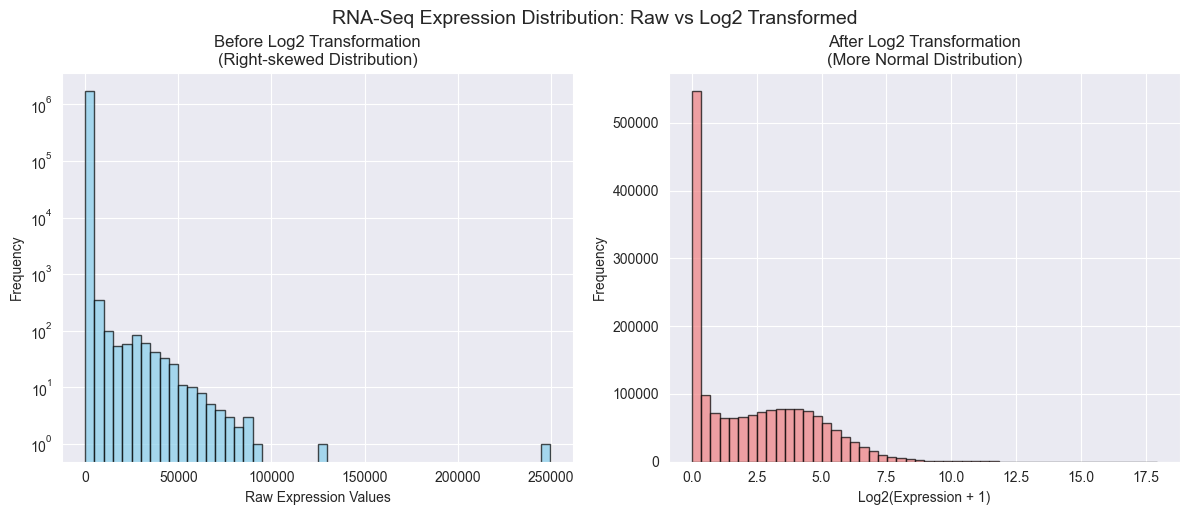

In [131]:
np.random.seed(42)
sample_genes = np.random.choice(combined_df.columns, size=1000, replace=False)
sample_data = combined_df[sample_genes]

# Flatten the data for plotting
raw_values = sample_data.values.flatten()
log2_values = np.log2(sample_data + 1).values.flatten()

# Create side-by-side histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Raw expression distribution
ax1.hist(raw_values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Raw Expression Values')
ax1.set_ylabel('Frequency')
ax1.set_title('Before Log2 Transformation\n(Right-skewed Distribution)')
ax1.set_yscale('log')  # Use log scale for y-axis due to extreme skew

# Log2 transformed distribution
ax2.hist(log2_values, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.set_xlabel('Log2(Expression + 1)')
ax2.set_ylabel('Frequency')
ax2.set_title('After Log2 Transformation\n(More Normal Distribution)')

plt.tight_layout()
plt.suptitle('RNA-Seq Expression Distribution: Raw vs Log2 Transformed', 
             fontsize=14, y=1.02)
plt.show()

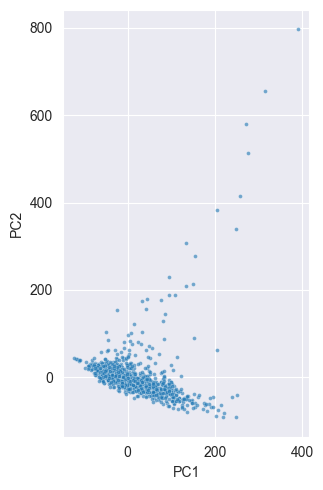

In [132]:
expr = combined_df.copy()

expr_z = StandardScaler().fit_transform(expr)

pca = PCA(n_components=2, random_state=0)
coords = pca.fit_transform(expr_z)

pc_df = pd.DataFrame(coords, columns=['PC1', 'PC2'], index=expr.index)

plt.figure(figsize=(6, 5))
sns.scatterplot(data=pc_df, x='PC1', y='PC2', s=8, alpha=0.6)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

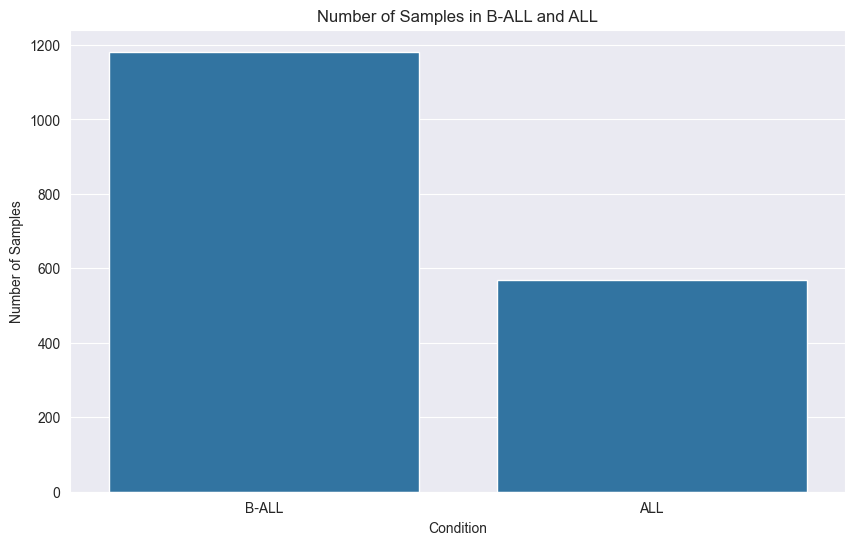

In [133]:
plt.figure(figsize=(10, 6))
sns.barplot(x=['B-ALL', 'ALL'], y=[len(df_b_all_filtered), len(df_all_filtered)])
plt.title('Number of Samples in B-ALL and ALL')
plt.ylabel('Number of Samples')
plt.xlabel('Condition')
plt.show()

Labeling

In [134]:
y = combined_df['condition']  # Use the 'condition' column as the target variable

combined_df.drop(columns=['condition'], inplace=True)  # Drop the 'condition' column for normalization

Main

Log2 Normalizing

In [135]:
merged_df_normalized = np.log2(combined_df + 1)  # Log2 transformation

In [136]:
merged_df_normalized.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

Scaler

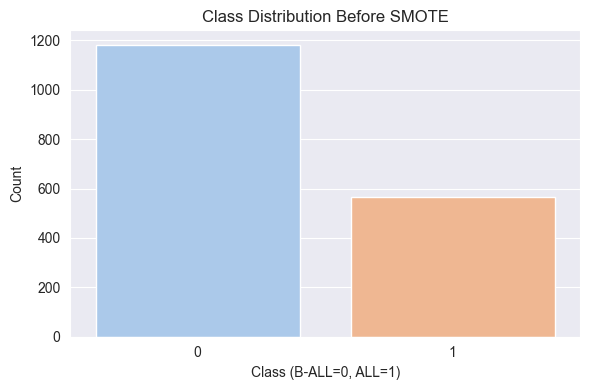

In [137]:
# Plot class distribution before SMOTE (using original y)
counts_before = pd.Series(y).value_counts().sort_index()
plt.figure(figsize=(6,4))
sns.barplot(x=counts_before.index, y=counts_before.values, palette="pastel")
plt.xlabel("Class (B-ALL=0, ALL=1)")
plt.ylabel("Count")
plt.title("Class Distribution Before SMOTE")
plt.tight_layout()
plt.show()

Optuna

In [174]:
trial_results = {"xgboost": [], "random_forest": [], "logistic_regression": []}

# Callback to record each trial's model type and its score.
def record_trial_callback(study, trial):
    classifier = trial.params.get("classifier")
    trial_results[classifier].append((trial.number, trial.value))

def optimize_classifier(x, y, n_trials=20):
    def objective(trial):
        k = trial.suggest_int("k", 20, merged_df_normalized.shape[0] / 4)  # k is capped at 1/4th of features.
        classifier_choice = trial.suggest_categorical("classifier", ["xgboost", "random_forest", "logistic_regression"])

        if classifier_choice == "xgboost":
            params = {
                "max_depth": trial.suggest_int("max_depth", 3, 15),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "n_estimators": trial.suggest_int("n_estimators", 50, 300),
                "tree_method": "hist",
                "objective": "binary:logistic",
                "eval_metric": "auc",
            }
            model = xgb.XGBClassifier(**params, use_label_encoder=False, verbosity=0)
        elif classifier_choice == "random_forest":
            params = {
                "n_estimators": trial.suggest_int("n_estimators_rf", 50, 300),
                "max_depth": trial.suggest_int("max_depth_rf", 3, 15),
                "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
            }
            model = RandomForestClassifier(**params, random_state=42, class_weight="balanced")
        elif classifier_choice == "logistic_regression":
            c_value = trial.suggest_float("C", 1e-4, 1e2, log=True)
            model = LogisticRegression(C=c_value, solver="liblinear",
                                       random_state=42, class_weight="balanced", max_iter=1000)
        else:
            raise ValueError("Unsupported classifier selected.")

        pipeline = Pipeline([
            # ('smote', SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=5)),
            # ("scaler", StandardScaler()),
            ("select_kbest", SelectKBest(score_func=f_classif, k=k)),
            ("classifier", model)
        ])


        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        score = cross_val_score(pipeline, x, y, scoring="roc_auc", cv=cv).mean()

        if np.isnan(score):
            print("NaN score encountered, returning a low score.")
            return 0.0
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, callbacks=[record_trial_callback])

    print("Best parameters:", study.best_params)
    print("Best ROC-AUC:", study.best_value)
    return study

# Run the optimization.
study_result = optimize_classifier(merged_df_normalized, y, n_trials=200)

[I 2025-06-23 21:33:16,999] A new study created in memory with name: no-name-0a79f227-d22b-43c6-a0fc-185202350a02
[I 2025-06-23 21:33:25,528] Trial 0 finished with value: 0.7380727799053084 and parameters: {'k': 260, 'classifier': 'random_forest', 'n_estimators_rf': 267, 'max_depth_rf': 6, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7380727799053084.
[I 2025-06-23 21:33:28,346] Trial 1 finished with value: 0.7174605610159199 and parameters: {'k': 139, 'classifier': 'xgboost', 'max_depth': 4, 'learning_rate': 0.21827546700432823, 'n_estimators': 254}. Best is trial 0 with value: 0.7380727799053084.
[I 2025-06-23 21:33:35,116] Trial 2 finished with value: 0.7411917920093336 and parameters: {'k': 237, 'classifier': 'random_forest', 'n_estimators_rf': 192, 'max_depth_rf': 7, 'criterion': 'entropy'}. Best is trial 2 with value: 0.7411917920093336.
[I 2025-06-23 21:33:36,000] Trial 3 finished with value: 0.7408574491328732 and parameters: {'k': 251, 'classifier': 'logistic_regress

Best parameters: {'k': 285, 'classifier': 'random_forest', 'n_estimators_rf': 50, 'max_depth_rf': 13, 'criterion': 'entropy'}
Best ROC-AUC: 0.7459998127675228


Apply Optuna result

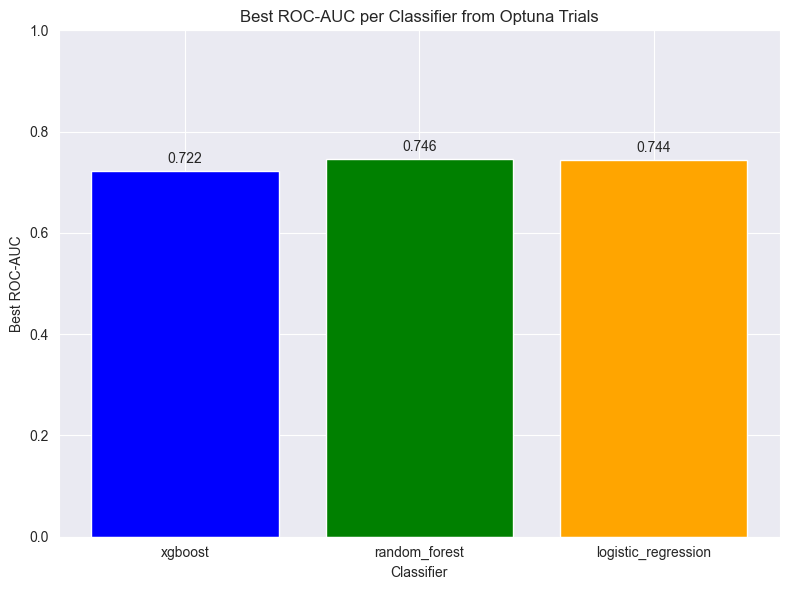

Plot saved to plots/best_classifier_comparison.png


In [175]:
best_scores = {}
for clf in trial_results:
    if trial_results[clf]:
        best_trial = max(trial_results[clf], key=lambda t: t[1])
        best_scores[clf] = best_trial[1]
    else:
        best_scores[clf] = 0

models = list(best_scores.keys())
scores = [best_scores[m] for m in models]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, scores, color=['blue', 'green', 'orange'])
plt.ylabel("Best ROC-AUC")
plt.xlabel("Classifier")
plt.title("Best ROC-AUC per Classifier from Optuna Trials")
plt.ylim(0, 1)
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{score:.3f}', ha='center', va='bottom')

if not os.path.exists("plots"):
    os.makedirs("plots")

plot_path = os.path.join("plots", "best_classifier_comparison.png")
plt.tight_layout()
plt.savefig(plot_path)
plt.show()

print(f"Plot saved to {plot_path}")

Select K Best

In [176]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(
    merged_df_normalized, y, test_size=0.2, random_state=42, stratify=y
)

# Get the best parameters from the study for every classifier
classifiers = ["xgboost", "random_forest", "logistic_regression"]

best_params = {}

# Gets the best parameters for each classifier from the study result
for classifier in classifiers:
    classifier_trials = [trial for trial in study_result.trials if trial.params.get("classifier") == classifier]

    if classifier_trials:
        best_trial = max(classifier_trials, key=lambda t: t.value if t.value is not None else -float('inf'))
        best_params[classifier] = {k: v for k, v in best_trial.params.items() if k != "classifier"}
    else:
        best_params[classifier] = {}

print(f"\nFinal best params for each classifier:")
for classifier, params in best_params.items():
    print(f"{classifier}: {params}")

best_k = None
for classifier, params in best_params.items():
    if 'k' in params:
        best_k = params['k']
        break

print(f"Best k value: {best_k}")



Final best params for each classifier:
xgboost: {'k': 243, 'max_depth': 8, 'learning_rate': 0.011861120592788614, 'n_estimators': 114}
random_forest: {'k': 285, 'n_estimators_rf': 50, 'max_depth_rf': 13, 'criterion': 'entropy'}
logistic_regression: {'k': 395, 'C': 0.0001008515736502143}
Best k value: 243


Training

In [177]:
best_params_lr = best_params['logistic_regression']
# Create the SelectKBest object
select_k_best = SelectKBest(score_func=f_classif, k=best_params_lr["k"])

# Fit and transform the training data
x_train_selected = select_k_best.fit_transform(x_train, y_train)

# Get the selected feature names
# Note: merged_df_normalized should be your original feature matrix before scaling
selected_feature_indices = select_k_best.get_support(indices=True)
selected_feature_names_lr = merged_df_normalized.columns[selected_feature_indices].tolist()

# Transform test data
x_test_selected = select_k_best.transform(x_test)

# Update your variables
x_train_lr = x_train_selected
x_test_lr = x_test_selected

model_lr = LogisticRegression(C=best_params_lr["C"], random_state=42, solver="liblinear", max_iter=1000, class_weight="balanced")

model_lr.fit(x_train_lr, y_train)

y_pred_lr = model_lr.predict(x_test_lr)

y_proba_lr = model_lr.predict_proba(x_test_lr)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba_lr)
print(f"ROC-AUC on test set: {roc_auc:.4f}")

ROC-AUC on test set: 0.7596


In [178]:
best_params_rf = best_params['random_forest']
# Create the SelectKBest object
select_k_best = SelectKBest(score_func=f_classif, k=best_params_rf["k"])

# Fit and transform the training data
x_train_selected = select_k_best.fit_transform(x_train, y_train)

# Get the selected feature names
# Note: merged_df_normalized should be your original feature matrix before scaling
selected_feature_indices = select_k_best.get_support(indices=True)
selected_feature_names_rf = merged_df_normalized.columns[selected_feature_indices].tolist()

# Transform test data
x_test_selected = select_k_best.transform(x_test)

# Update your variables
x_train_rf = x_train_selected
x_test_rf = x_test_selected

model_rf = RandomForestClassifier(random_state=42, class_weight="balanced", n_estimators=best_params_rf["n_estimators_rf"],
                               max_depth=best_params_rf["max_depth_rf"], criterion=best_params_rf["criterion"])

model_rf.fit(x_train_rf, y_train)
y_pred_rf = model_rf.predict(x_test_rf)
y_proba_rf = model_rf.predict_proba(x_test_rf)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba_rf)
print(f"ROC-AUC on test set: {roc_auc:.4f}")

ROC-AUC on test set: 0.7744


In [179]:
best_params_xg = best_params['xgboost']

select_k_best = SelectKBest(score_func=f_classif, k=best_params_xg["k"])

# Fit and transform the training data
x_train_selected = select_k_best.fit_transform(x_train, y_train)
# Get the selected feature names
selected_feature_indices = select_k_best.get_support(indices=True)
selected_feature_names_xg = merged_df_normalized.columns[selected_feature_indices].tolist()
# Transform test data
x_test_selected = select_k_best.transform(x_test)
# Update your variables
x_train_xg = x_train_selected
x_test_xg = x_test_selected
model_xg = xgb.XGBClassifier(
    max_depth=best_params_xg["max_depth"],
    learning_rate=best_params_xg["learning_rate"],
    n_estimators=best_params_xg["n_estimators"],
    tree_method="hist",
    objective='binary:logistic',
    eval_metric="auc",
    use_label_encoder=False,
    verbosity=0,
)
model_xg.fit(x_train_xg, y_train)
y_pred_xg = model_xg.predict(x_test_xg)
y_proba_xg = model_xg.predict_proba(x_test_xg)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba_xg)
print(f"ROC-AUC on test set: {roc_auc:.4f}")

ROC-AUC on test set: 0.7457


### Statistics and Plots

Confusion Matrix

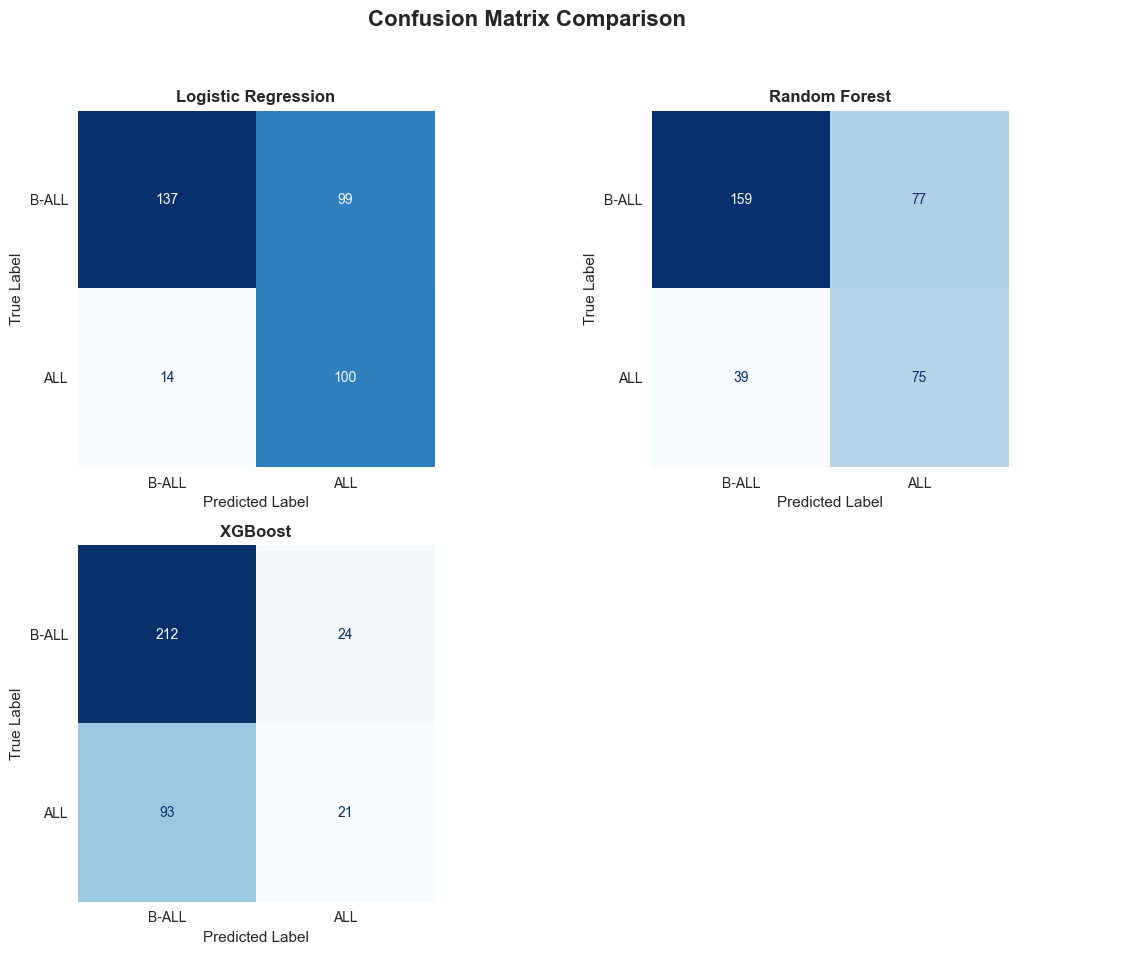

Combined confusion matrices saved to plots/confusion_matrices_combined.png


In [211]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

# Set seaborn style for consistency (without grid for confusion matrices)
sns.set_style("white")

# Create 2x2 subplot with tighter spacing
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Confusion Matrix Comparison', fontsize=16, fontweight='bold')

# Model data with names
y_preds = [y_pred_lr, y_pred_rf, y_pred_xg]
model_names = ["Logistic Regression", "Random Forest", "XGBoost"]

# Plot confusion matrices
for idx, (y_pred, name) in enumerate(zip(y_preds, model_names)):
    row = idx // 2
    col = idx % 2

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create display object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["B-ALL", "ALL"])

    # Plot on specific subplot
    disp.plot(ax=axes[row, col], cmap='Blues', colorbar=False)
    axes[row, col].set_title(f'{name}', fontweight='bold', fontsize=12)
    axes[row, col].set_xlabel("Predicted Label")
    axes[row, col].set_ylabel("True Label")
    axes[row, col].grid(False)  # Remove grid lines

# Remove the empty 4th subplot
axes[1, 1].axis('off')

# Adjust layout for tighter spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for suptitle

# Save the combined plot
confusion_matrix_path = os.path.join("plots", "confusion_matrices_combined.png")
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Combined confusion matrices saved to {confusion_matrix_path}")

Precision recall curve

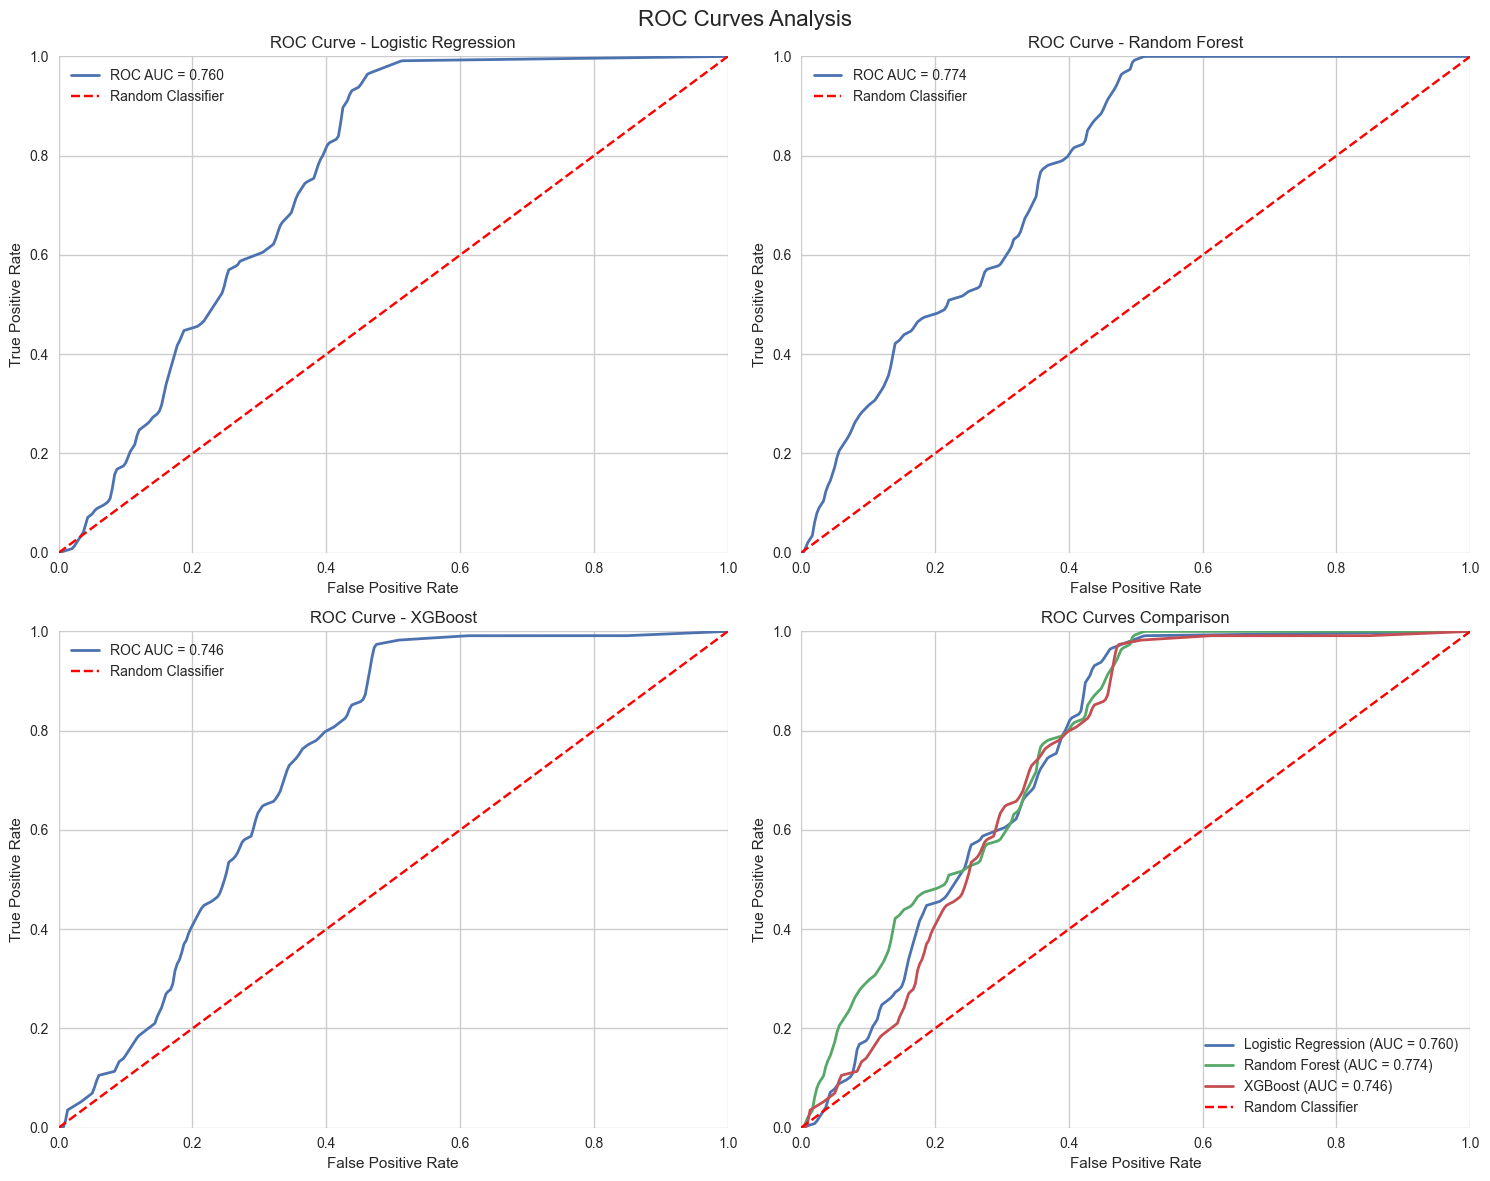

In [210]:

y_probas = [(y_proba_lr, "Logistic Regression"), (y_proba_rf, "Random Forest"), (y_proba_xg, "XGBoost")]

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('ROC Curves Analysis', fontsize=16)

# Individual plots in first 3 subplots
for i, (y_proba, name) in enumerate(y_probas):
    row = i // 2
    col = i % 2

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Remove duplicates and sort for interpolation
    unique_indices = np.unique(fpr, return_index=True)[1]
    fpr_unique = fpr[unique_indices]
    tpr_unique = tpr[unique_indices]

    # Create smooth curves using linear interpolation (more conservative)
    if len(fpr_unique) > 2:
        fpr_smooth = np.linspace(0, 1, 300)
        interp_func = interp1d(fpr_unique, tpr_unique, kind='linear', bounds_error=False, fill_value=(0, 1))
        tpr_smooth = interp_func(fpr_smooth)
        # Ensure values stay within bounds
        tpr_smooth = np.clip(tpr_smooth, 0, 1)
        axes[row, col].plot(fpr_smooth, tpr_smooth, linewidth=2, label=f'ROC AUC = {roc_auc:.3f}')
    else:
        axes[row, col].plot(fpr, tpr, linewidth=2, label=f'ROC AUC = {roc_auc:.3f}')

    axes[row, col].plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')
    axes[row, col].set_xlabel('False Positive Rate')
    axes[row, col].set_ylabel('True Positive Rate')
    axes[row, col].set_title(f'ROC Curve - {name}')
    axes[row, col].legend()
    axes[row, col].grid(True)
    axes[row, col].set_xlim([0, 1])
    axes[row, col].set_ylim([0, 1])

# Combined plot in the 4th subplot (bottom right)
for y_proba, name in y_probas:
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Remove duplicates and sort for interpolation
    unique_indices = np.unique(fpr, return_index=True)[1]
    fpr_unique = fpr[unique_indices]
    tpr_unique = tpr[unique_indices]

    # Create smooth curves using linear interpolation
    if len(fpr_unique) > 2:
        fpr_smooth = np.linspace(0, 1, 300)
        interp_func = interp1d(fpr_unique, tpr_unique, kind='linear', bounds_error=False, fill_value=(0, 1))
        tpr_smooth = interp_func(fpr_smooth)
        # Ensure values stay within bounds
        tpr_smooth = np.clip(tpr_smooth, 0, 1)
        axes[1, 1].plot(fpr_smooth, tpr_smooth, linewidth=2, label=f'{name} (AUC = {roc_auc:.3f})')
    else:
        axes[1, 1].plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.3f})')

axes[1, 1].plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curves Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True)
axes[1, 1].set_xlim([0, 1])
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

    SHAP

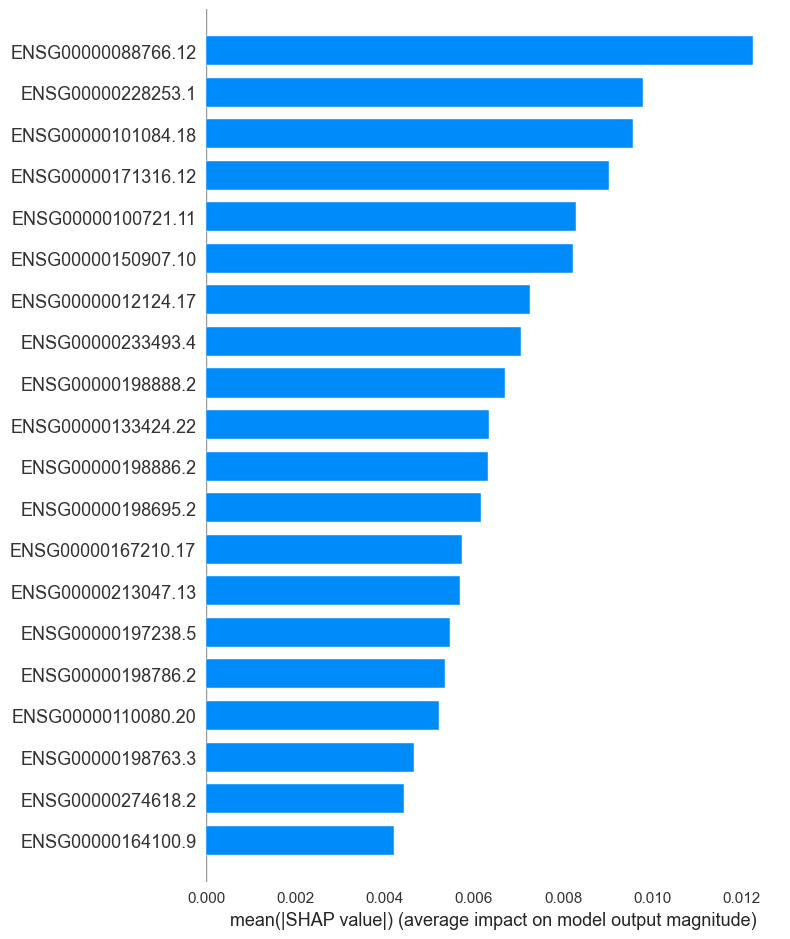

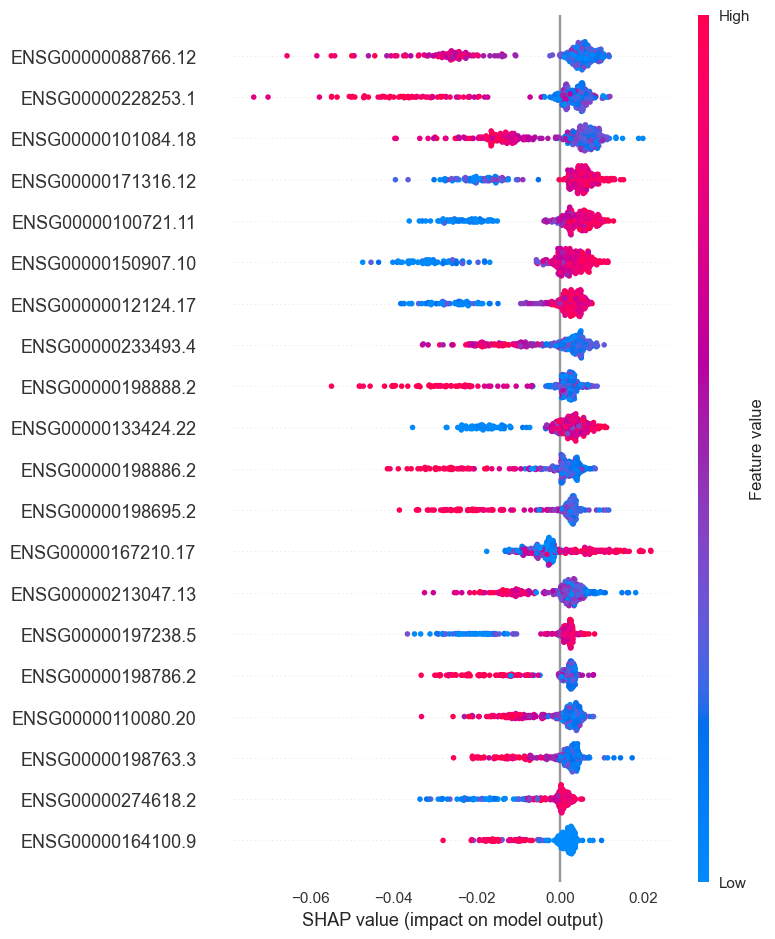

In [226]:
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(x_test_rf)


x_test_df = pd.DataFrame(x_test_rf, columns=selected_feature_names_rf)

# For binary classification, visualize class 1 (positive class)
shap.summary_plot(shap_values[:, :, 1], x_test_df, plot_type="bar")
plt.show()

shap.summary_plot(shap_values[:, :, 1], x_test_df)  # beeswarm plot
plt.show()

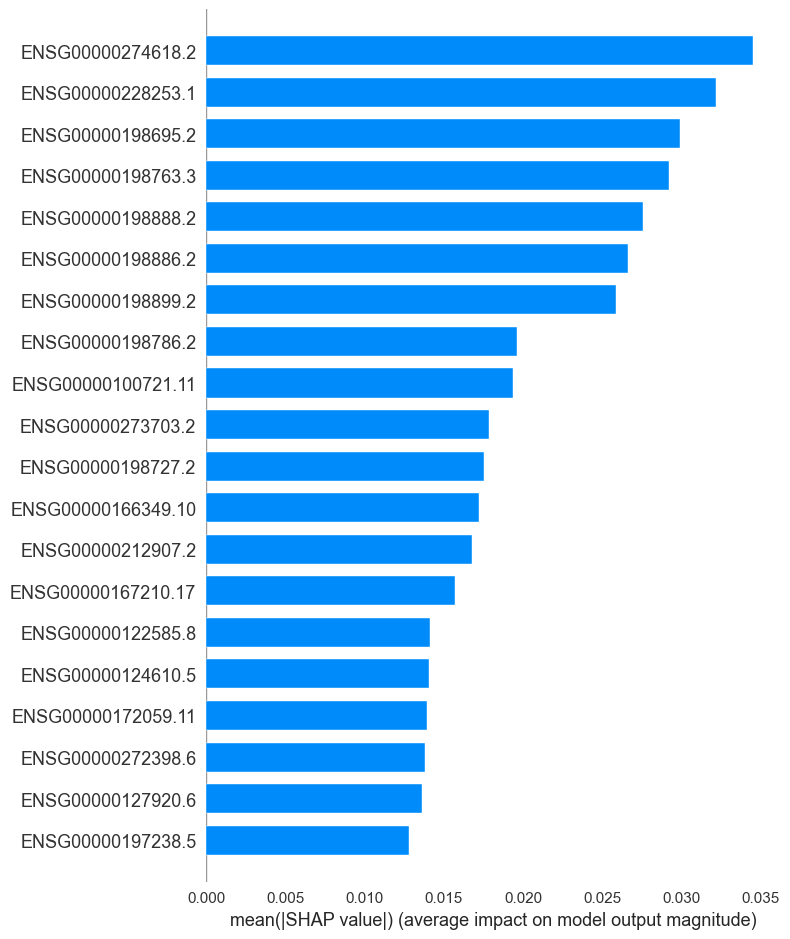

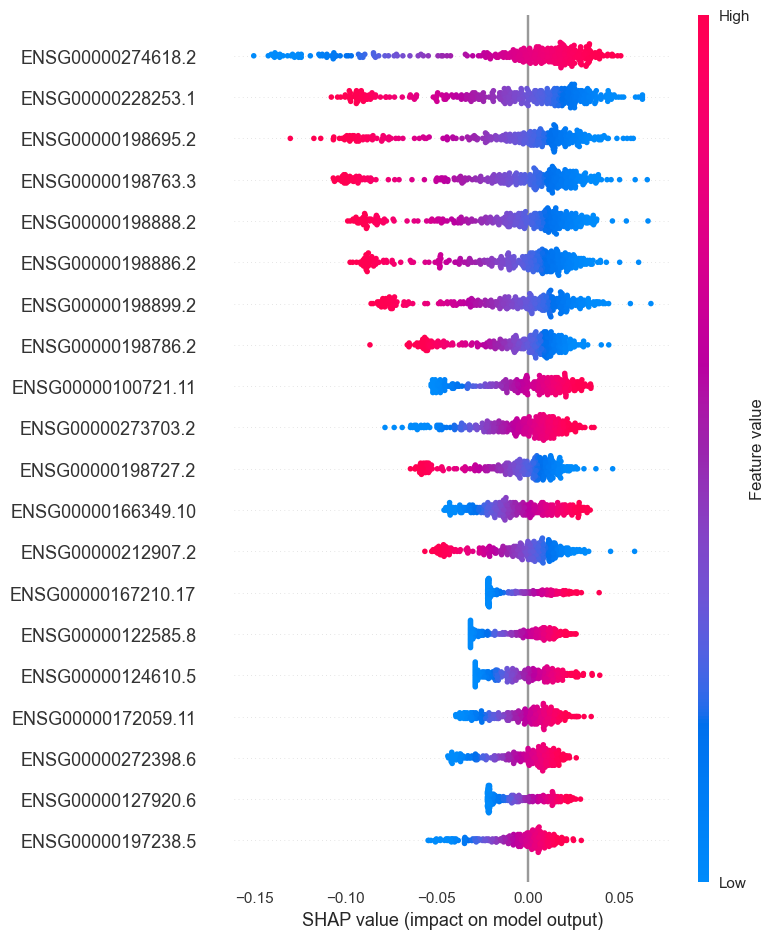

<Figure size 800x550 with 0 Axes>

In [225]:
explainer = shap.Explainer(model_lr, x_train_lr)
shap_values = explainer.shap_values(x_test_lr)

x_test_df = pd.DataFrame(x_test_lr, columns=selected_feature_names_lr)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, x_test_df, plot_type="bar", title="SHAP Values for Logistic Regression")
plt.tight_layout()

shap.summary_plot(shap_values, x_test_df)  # beeswarm plot

shap_plot_path = os.path.join("plots", "shap_summary_plot.png")
plt.savefig(shap_plot_path, dpi=300, bbox_inches='tight')

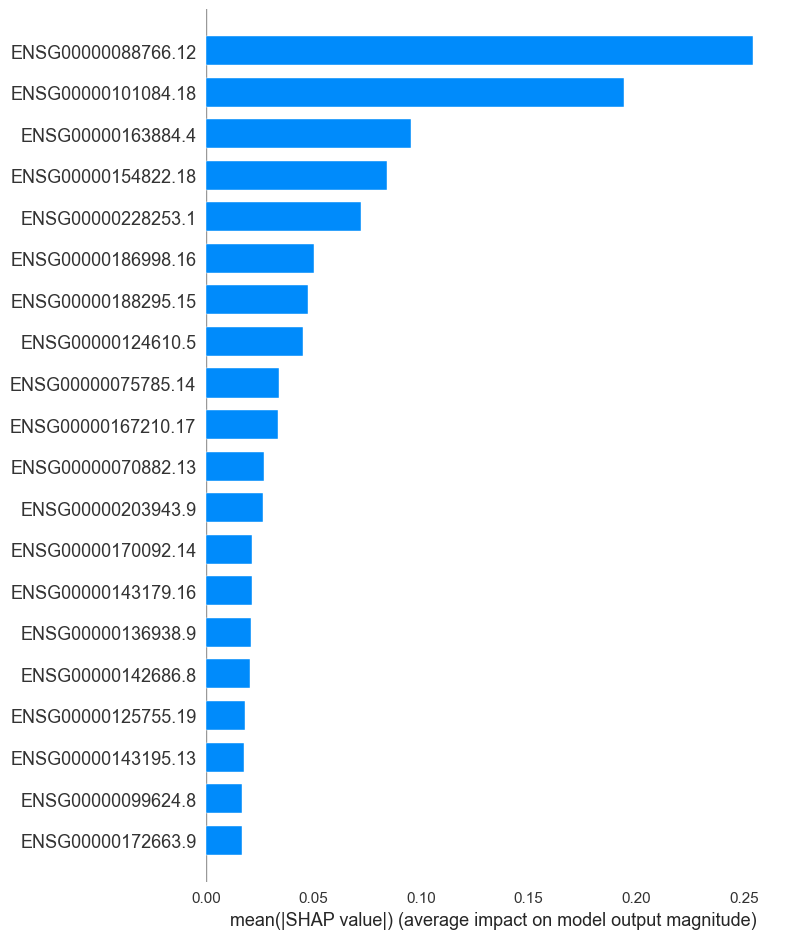

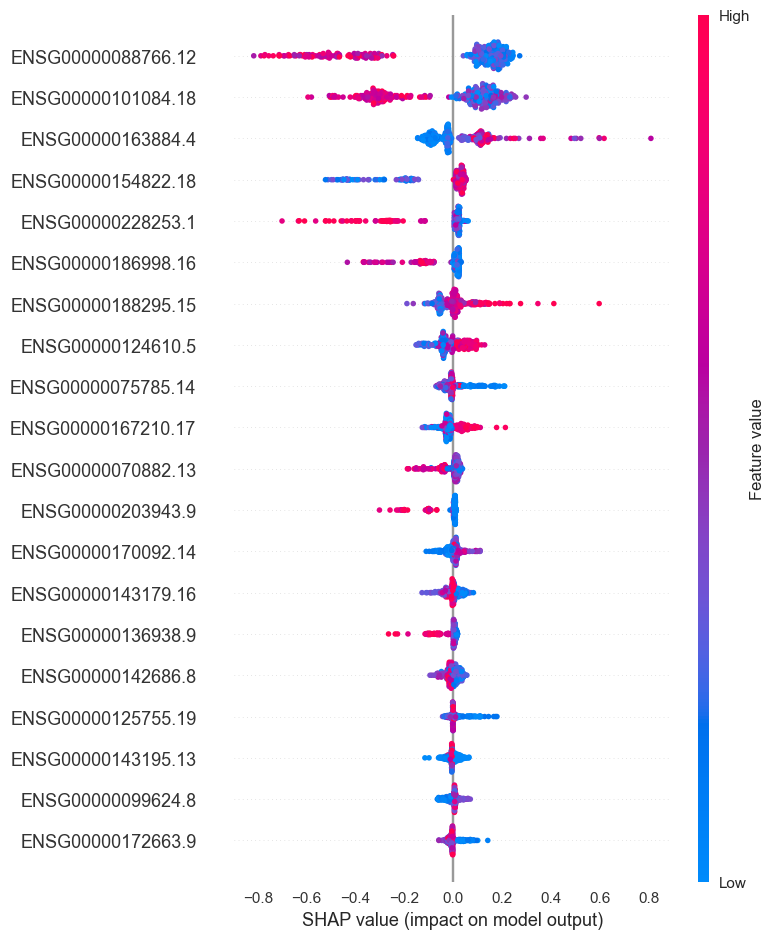

In [224]:
explainer = shap.TreeExplainer(model_xg)
shap_values = explainer.shap_values(x_test_xg)


x_test_df = pd.DataFrame(x_test_xg, columns=selected_feature_names_xg)

# For binary classification, visualize class 1 (positive class)
shap.summary_plot(shap_values, x_test_df, plot_type="bar")
plt.show()

shap.summary_plot(shap_values, x_test_df)  # beeswarm plot
plt.show()